### sources

- wordcloud
    - https://png-clipart.blogspot.com/2011/03/clip-art-student-tree.html
    - https://github.com/amueller/word_cloud
    - https://github.com/amueller/word_cloud/blob/master/examples/masked.py

- hashtags
    - https://stackoverflow.com/questions/54761797/how-to-preserve-hashtag-and-mention-characterizers-from-countvectorizer-token
- https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp

In [420]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
import sys
from pprint import pprint



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import regex as re

In [415]:
## Helpers

def custom_preprocessor(text):
    """
    Taken from https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp
    """
    #lowering the text case
    text = text.lower() 
    # remove special chars
    text = re.sub("\\W"," ",text)
    return text

In [418]:
class Main:
    def __init__(self, name, to_model=True):
        self.name = name
        self.images_path = '../presentation/images'
        self.set_data_path()
        self.read_data()
        self.get_stop_words()
        self.preprocess_data()
        self.get_X_y()
        self.run_train_test_split()
        self.get_baseline_info()
        
        self.do_eda()
        self.feature_extract(transformer='CountVectorizer')
        self.feature_extract(transformer='TfidfVectorizer')


        
        if to_model:
            info_list = []
            info = self.modeling(estimator='MultinomialNB', transformer='CountVectorizer')
            info_list.append(info)


            info = self.modeling(estimator='MultinomialNB', transformer='TfidfVectorizer')
            info_list.append(info)
   
            info = self.modeling(estimator='DecisionTreeClassifier', transformer='TfidfVectorizer')
            info_list.append(info)


            info = self.modeling(estimator='DecisionTreeClassifier', transformer='CountVectorizer')
            info_list.append(info)

            
#             info = self.modeling(estimator='RandomForestClassifier',transformer='CountVectorizer')
#             info_list.append(info)


            info  = self.modeling(estimator='RandomForestClassifier', transformer='TfidfVectorizer')
            info_list.append(info)
            
            self.info_list = info_list
            
            self.info_df = pd.DataFrame(self.info_list).set_index(['Estimator', 'Transformer'])
            display(self.info_df)
            



            

        
    def set_data_path(self):
        if self.name == 'reddit':
            #self.path = '/content/drive/MyDrive/Colab Notebooks/Meditation_Yoga.csv'
            self.path = '../data/original/Meditation_Yoga.csv'
            self.sep = ','


        
    def read_data(self):
        self.data = pd.read_csv(self.path, sep=self.sep)
        if self.name == "spam":
            self.data.columns = ['label', 'message']

        # What is the size of our data set?
        print('shape: ', self.data.shape)
        display(self.data.head(1))
        
        
    def preprocess_data(self):
        """
        Preprocess the data.
        Clean the text.
        Replace characters.
        Lemmatize the sentences.
        """
        if self.name == "reddit":
            self.original_text_field = 'text'
            self.text_field = "clean_text"
            self.target_field = "label"
            self.main_target_field = "subreddit"
            # Create label column
            
            self.data['text'] = self.data['text'].str.lower()
            for pattern in ['&gt', '&le', '#x200b', '&amp;#x200b', r'http\S+']:
                self.data['text'] = self.data['text'].str.replace(pattern, '', regex=True)
            self.data['original_text'] = self.data['text']
                
            replacements = {"don't": "do not", "I've": "I have", 
                            '&amp;amp;':'&',
                            "'ve": ' have', '\n': ' ', 'poses': 'pose', 
                            "doesn't": "does not"}
            
            for k, v in replacements.items():
                self.data['text'] = self.data['text'].str.replace(k, v, regex=True)
                

            lemmatizer = WordNetLemmatizer()
            self.data['text'] = self.data['text'].apply(lambda t: ' '.join([word for word in 
                                                                            t.split(' ') if word not in self.stop_words]))
            self.data['text'] = self.data['text'].apply(lambda t: ' '.join([lemmatizer.lemmatize(word) 
                                                                            for word in t.split(' ')]))


            self.data['text'] = self.data['text'].str.replace('\d+', ' ', regex=True)
            
            self.data['clean_text'] = self.data['text'].str.replace('_', ' ')
            self.data['subreddit'] = self.data['subreddit'].str.title()
            self.data['label'] = self.data['subreddit'].map({'Meditation':1, 'Yoga':0})
            self.reverse_map = {1: 'Meditation', 0: 'Yoga'}
            self.display_labels=['Yoga', 'Meditation']
            
            
        self.data['Length'] = self.data['original_text'].apply(len)
        self.data['Word Count']= self.data['original_text'].apply(lambda x: len(x.split()))
        
        self.data['Title Length'] = self.data['title'].apply(len)
        self.data['Title Word Count']= self.data['title'].apply(lambda x: len(x.split()))
        
        self.data['Content Length'] = self.data['selftext'].apply(len)
        self.data['Content Word Count']= self.data['selftext'].apply(lambda x: len(x.split()))
            

    def get_X_y(self):
        """
        Extract X and y
        """

        self.X = self.data[self.text_field]
        self.y = self.data[self.target_field]
        
        
    def run_train_test_split(self, random_state=42, test_size=.3):
        """
        Split the data into the training and testing sets.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, 
                                                            test_size=test_size, 
                                                            stratify=self.y, 
                                                            random_state=random_state)

        print('\nSize of X train: ', sys.getsizeof(self.X_train))

        
    def get_stop_words(self):
        """
        Get the English stope words and add more stop words to it.
        """
        words = list(CountVectorizer(stop_words='english').get_stop_words())
        
        if self.name == 'reddit':
        
            words.extend(['www', 'https', 'like', 'just', 'day', 'week', 'time', 'month', 'year', 'ask', 'question', 'thread', 'discus', 'discussion'])
            words.extend(['doe', 'don', 'thing', 'really', 'ago', 've'])
            words.extend(['meditation', 'yoga', 'meditate', 'meditating', 'meditated', 'cmrmeditation', 'heightsmeditationyoga', 'meditates', 'meditations', 'meditationtm', 'meditative', 'meditator', 
                          'meditators', 'unpremeditated', 'authenticyogastudio', 'gayogayogayo', 'hathayoga', 'heightsmeditationyoga', 'ishavasyamyogaschool', 
                          'kidsyoga', 'mardayoga', 'modernyogateacher', 'myoga', 'onlineyoga', 'poweryoga', 'pranavayoga', 'sarahbethyoga', 'siddhiyoga', 
                          'tyoga', 'yinyoga', 'yogaalliance', 'yogabydaisy', 'yogaday', 'yogaeverydamnday', 'yogaeveryday', 'yogaeverywhere', 'yogaforsale', 
                          'yogagirl', 'yogainspiration', 'yogajourney', 'yogalates', 'yogalife', 'yogalive', 'yogalove', 'yoganewbie', 'yogaonyork', 
                          'yogapose', 'yogaposes', 'yogapractice', 'yogaretreat', 'yogi',
                          'yogas', 'yogateacher', 'yogateachers', 'yogateachertraining', 'yogateachertrainingcourse', 'yogatraining', 'yogatx'])
            words.extend(['x200b'])
        self.stop_words = words
    
    
    def get_baseline_info(self):
        """
        Compute and display the baseline accuracy.
        """
        
        print(f'\nBaseline Accuracy - y: {self.y.value_counts(normalize=True)[0].round(3)}')
        print(f'\nBaseline Accuracy - y test: {self.y_test.value_counts(normalize=True)[0].round(3)}')
        
        display(self.y.value_counts())
        
        self.baseline_accuracy = self.y_test.value_counts(normalize=True)[0].round(3)
        
        
    def feature_extract(self, remove_stop_words=True, transformer='CountVectorizer', ngram_range=(1,1)):
        """
        Instantiate a CountVectorizer or TfidfVectorizer.
        Vectorize the X train and X test
        """
        if remove_stop_words:
            fe = eval(transformer)(stop_words = self.stop_words, preprocessor=custom_preprocessor, 
                                   ngram_range=ngram_range, max_df=.85)
        else:
            fe = eval(transformer)()
            
        fe.fit(self.X_train)
        X_train_tf = fe.transform(self.X_train)

            
        # Transform test
        X_test_tf = fe.transform(self.X_test)
        # cvec.vocabulary_

        self.X_train_df = pd.DataFrame(X_train_tf.todense(), columns=fe.get_feature_names())
        self.X_test_df = pd.DataFrame(X_test_tf.todense(), columns=fe.get_feature_names())

        

    def plot_distributions(self):
        """
        Plot histograms for the distributions of character length and word length
        """
        fig, ax = plt.subplots(1, 2, figsize=(16, 6));
        g0 = sns.histplot(self.data, x='Length', hue=self.main_target_field, ax = ax[0], kde=True, legend=False, alpha=.45);
        g1 = sns.histplot(self.data, x='Word Count', hue=self.main_target_field, ax = ax[1], kde=True, alpha=.45);
        g0.set(title='Character Length Distributions')
        g1.set(title='Word Count Distributions')
        ax[0].set_xlim(None, 4000)
        ax[1].set_xlim(None, 600)
        ax[1].set_ylabel('');
        sns.despine(top=True);
        fig.suptitle('Title+Content', fontsize=20);
        plt.savefig(f'{self.images_path}/character_word_count_dist_title_content.png', bbox_inches='tight', dpi=300)
        
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 6));
        g0 = sns.histplot(self.data, x='Title Length', hue=self.main_target_field, ax = ax[0], kde=True, legend=False, alpha=.45);
        g1 = sns.histplot(self.data, x='Title Word Count', hue=self.main_target_field, ax = ax[1], kde=True, alpha=.45);
        g0.set(title='Character Length Distributions')
        g1.set(title='Word Count Distributions')
        ax[1].set_ylabel('');
        sns.despine(top=True);
        fig.suptitle('Title', fontsize=20);
        plt.savefig(f'{self.images_path}/character_word_count_dist_title.png', bbox_inches='tight', dpi=300)
        

        fig, ax = plt.subplots(1, 2, figsize=(16, 6));
        g0 = sns.histplot(self.data, x='Content Length', hue=self.main_target_field, ax = ax[0], kde=True, legend=False, alpha=.45);
        g1 = sns.histplot(self.data, x='Content Word Count', hue=self.main_target_field, ax = ax[1], kde=True, alpha=.45);
        g0.set(title='Character Length Distributions')
        g1.set(title='Word Count Distributions')
        ax[0].set_xlim(None, 4000)
        ax[1].set_xlim(None, 600)
        ax[1].set_ylabel('');
        sns.despine(top=True);
        fig.suptitle('Content', fontsize=20);
        plt.savefig(f'{self.images_path}/character_word_count_dist_content.png', bbox_inches='tight', dpi=300)
        
        
    def do_eda(self):
        """
        Plot Distributions, bar charts for frequently occurring words.
        """
        self.plot_distributions()
        self.get_top_occurring('CountVectorizer', count=15, ngram_range = (3,3))
        self.get_top_occurring('TfidfVectorizer', count=15, ngram_range = (3,3))
        self.get_top_occurring('CountVectorizer', count=15, ngram_range = (2,2))
        self.get_top_occurring('TfidfVectorizer', count=15, ngram_range = (2,2))
        self.get_top_occurring('CountVectorizer', count=15, ngram_range = (1,1))
        self.get_top_occurring('TfidfVectorizer', count=15, ngram_range = (1,1))
        self.get_top_occurring_separated(count=15, ngram_range = (3,3))
        self.get_top_occurring_separated(count=15, ngram_range = (2,2))
        self.get_top_occurring_separated(count=15, ngram_range = (1,1))
        self.get_hashtags_separated(count=10)
        
    def get_hashtags_separated(self, count=10):
        """
        Extract the hashtags for each subreddit.
        """
        data0 = self.data[self.data[self.target_field]==0]
        data1 = self.data[self.data[self.target_field]==1]
        
        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=(1,1), token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')

        vect_df0 = pd.DataFrame(cv.fit_transform(data0['original_text']).todense(), columns = cv.get_feature_names())
        vect_df1 = pd.DataFrame(cv.fit_transform(data1['original_text']).todense(), columns = cv.get_feature_names())
        
        self.one_gram_features_0 = vect_df0.columns.tolist()
        self.one_gram_features_1 = vect_df1.columns.tolist()

        self.hashtags0 = pd.DataFrame(vect_df0.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        self.hashtags1 = pd.DataFrame(vect_df1.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        

        self.hashtags0.index.name = 'word'
        self.hashtags0.reset_index(inplace=True)
        self.hashtags1.index.name = 'word'
        self.hashtags1.reset_index(inplace=True)
        
        self.hashtags0 = self.hashtags0[self.hashtags0['word'].str.startswith('#')]
        self.hashtags1 = self.hashtags1[self.hashtags1['word'].str.startswith('#')]
        
        self.hashtags_0 = [x for x in self.one_gram_features_0 if x.startswith('#')]
        self.hashtags_1 = [x for x in self.one_gram_features_1 if x.startswith('#')]
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        g = sns.barplot(data=self.hashtags0.head(count), y='word', x='count', ax=ax[0], 
                        edgecolor=sns.color_palette("flare", 10),
                        facecolor=(0, 0, 0, 0));
        g.set_title(f'{self.reverse_map[0]}');
        g = sns.barplot(data=self.hashtags1.head(count), y='word', x='count', ax=ax[1], 
                        edgecolor=sns.color_palette("crest", count),
                        facecolor=(0, 0, 0, 0));
        ax[1].set_ylabel('');
        ax[0].set_ylabel('');
        ax[0].set_xlabel('');
        ax[1].set_xlabel('');
        g.set_title(f'{self.reverse_map[1]}');
        sns.despine(top=True);
        ax[0].tick_params(left=False, right=False, bottom=False);
        ax[1].tick_params(left=False, right=False, bottom=False);
        ax[0].tick_params(axis="y",direction="in", pad=-200)
        ax[1].tick_params(axis="y",direction="in", pad=-200)
        plt.subplots_adjust(wspace=0, hspace=0)
        display(self.hashtags0)
        display(self.hashtags1)
        plt.savefig(f'{self.images_path}/hashtags.png', bbox_inches='tight', dpi=300)

        
        
    def get_top_occurring_separated(self, count=10, ngram_range = (1,2)):
        """
        Extract the commonly occurring words for each subreddit
        """
        data0 = self.data[self.data[self.target_field]==0]
        data1 = self.data[self.data[self.target_field]==1]
        

        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=ngram_range, token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')
        
         

        vect_df0 = pd.DataFrame(cv.fit_transform(data0[self.original_text_field]).todense(), columns = cv.get_feature_names())
        vect_df1 = pd.DataFrame(cv.fit_transform(data1[self.original_text_field]).todense(), columns = cv.get_feature_names())
        


        self.top_occurring0 = pd.DataFrame(vect_df0.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        self.top_occurring1 = pd.DataFrame(vect_df1.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        self.top_occurring0.index.name = 'word'
        self.top_occurring0.reset_index(inplace=True)
        self.top_occurring1.index.name = 'word'
        self.top_occurring1.reset_index(inplace=True)
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        g = sns.barplot(data=self.top_occurring0.head(count), y='word', x='count', ax=ax[0], 
                        edgecolor=sns.color_palette("flare", 10),
                        facecolor=(0, 0, 0, 0));
        g.set_title(f'{self.reverse_map[0]}');
        g = sns.barplot(data=self.top_occurring1.head(count), y='word', x='count', ax=ax[1], 
                        edgecolor=sns.color_palette("crest", count),
                        facecolor=(0, 0, 0, 0));
        ax[1].set_ylabel('');
        ax[0].set_ylabel('');
        g.set_title(f'{self.reverse_map[1]}');
        sns.despine(top=True);
        ax[0].tick_params(left=False, right=False, bottom=False);
        ax[1].tick_params(left=False, right=False, bottom=False);
        if ngram_range[1]==3:
            pad = -240
        else:
            pad = -150
        ax[0].tick_params(axis="y",direction="in", pad=pad)
        ax[1].tick_params(axis="y",direction="in", pad=pad)
        fig.suptitle(f'{ngram_range[1]}-gram Words', fontsize=30);
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(f'{self.images_path}/top_occurring_ngram_{ngram_range[0]}_{ngram_range[1]}.png', bbox_inches='tight', dpi=300)

    def get_top_occurring(self, transformer, ngram_range=(1,2), count=20):
        """
        Get the top occurring words in all the data.
        """
        
        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=ngram_range, 
                             token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')
        
        vect_df = pd.DataFrame(cv.fit_transform(self.data[self.original_text_field]).todense(), columns = cv.get_feature_names())
        top_occurring = pd.DataFrame(vect_df.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        top_occurring.index.name = 'word'
        top_occurring.reset_index(inplace=True)
        self.top_occurring = top_occurring
        #display(top_occurring)
        plt.figure(figsize=(15, 10))
        g = sns.barplot(data=self.top_occurring.head(count), y='word', x='count',
                       edgecolor=sns.color_palette("colorblind", count),
                        facecolor=(0, 0, 0, 0));
        
#         fig.suptitle(f'{ngram_range[1]}-gram Words', fontsize=30);
        g.set_title(f'{ngram_range[1]}-gram Words');
        sns.despine(top=True);
        g.set_ylabel('');
        g.tick_params(left=False, right=False, bottom=False);
        if ngram_range[1]==3:
            pad = -270
        else:
            pad = -200
        g.tick_params(axis="y",direction="in", pad=pad)
        plt.savefig(f'{self.images_path}/all_top_occurring_{transformer}_ngram_{ngram_range[0]}_{ngram_range[1]}.png', 
                    bbox_inches='tight', dpi=300)
        
    def do_grid_search(self, mdl, param_grid, cv = 5, results={}):

        # Instantiate GridSearchCV.
        gs = GridSearchCV(
            # what object are we optimizing?
            estimator = mdl,
            # what parameters values are we searching?
            param_grid = param_grid,
            # 5-fold cross-validation.
            cv = cv,
            n_jobs = -1
        )

        # Fit GridSearch to training data.
        gs.fit(self.X_train, self.y_train)

        # What's the best score?
        best_score = gs.best_score_

        # What are the best hyperparameters?
        best_hyperparameters = gs.best_params_

        # Score model on training set.
        train_score = gs.score(self.X_train, self.y_train)

        # Score model on testing set.
        test_score = gs.score(self.X_test, self.y_test)


        print('\n\tGrid Search Results')
        print('\t\tBest Parameters')
        for k, v in best_hyperparameters.items():
            print(f'\t\t{k} : {v}')

        print('\n\t\tBest Score ', best_score.round(3))
        print('\t\tTrain Score: ', train_score.round(3))
        print('\t\tTest Score: ', test_score.round(3))
        
        results.update({
            'Grid Search\nGiven Parameters': param_grid,
            'Grid Search\nBest Score': best_score.round(3),
            'Grid Search\nTrain Score': train_score.round(3),
            'Grid Search\nTest Score': test_score.round(3),
            'Grid Search\nBest Hyperparameters': best_hyperparameters
            })
        return gs, results
    
    
    def make_confusion_matrix(self, mdl, results={}):
        """
        Plot the confusion matrix.
        """
        # Get predictions
        self.preds = mdl.predict(self.X_test)

        # Save confusion matrix values
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.preds).ravel()


        # View confusion matrix
        disp = plot_confusion_matrix(mdl, self.X_test, self.y_test, cmap='Blues', 
                                     values_format='d', display_labels=self.display_labels);


        # Calculate the specificity (TRUE NEG RATE)
        spec = tn/(tn + fp)

        # calculate precision
        prec = tp / (tp + fp)
        f1 = 2 * tp / (2*tp+fp+fn)
        
        sens = tp / (tp + fn)
        
        acc = (tn + tp) / (tn + fp + fn + tp)

        print('\tF1 - score: ', f1.round(3))
        print('\tRecall (Sensitivity): ', sens.round(3))
        print('\tSpecificity (True Negative Rate): ', spec.round(3))
        print('\tPrecision: ', prec.round(3))
        print('\tAccuracy: ', acc.round(3))
        results.update({
            'F1 - score': f1.round(3),
            'Recall (Sensitivity)': sens.round(3),
            'Specificity (True Negative Rate)': spec.round(3),
            'Precision': prec.round(3),
            'Accuracy': acc.round(3),
            
        })
        plt.text(3, -1.5, f'Accuracy: {acc.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, -1, f'Precision: {prec.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, -.5, f'F1 - score: {f1.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, 0, f'Recall (Sensitivity): {sens.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, .5, f'Specificity (True Negative Rate): {spec.round(2)*100:.0f}%', fontsize=20)
        
        indent = .5
        for k, v in results['Grid Search\nBest Hyperparameters'].items():
            indent+=.5
            plt.text(3, indent, f"{k.split('__')[1]}: {v}", fontsize=20)
        return disp, results
    
    def modeling(self, 
                 estimator='MultinomialNB',
                 transformer='CountVectorizer',
                 grid_search=True,
                 cv = 5):
        """
        Model the data with the given parameters.
        """

        # Let's set a pipeline up with two stages:
        # 1. CountVectorizer (transformer) or tf-idf vectorizer (transformer)
        # 2. Multinomial Naive Bayes (estimator)

        if transformer in ['CountVectorizer', 'TfidfVectorizer']:
            transformer_short = 'vec'

        if estimator == 'MultinomialNB':
            estimator_short = 'nb'
            
        if estimator == 'DecisionTreeClassifier':
            estimator_short = 'dt'
            
        if estimator == "RandomForestClassifier":
            estimator_short = 'rf'
            #grid_search = False

        pipe = Pipeline([
            (transformer_short, eval(transformer)(stop_words=self.stop_words, ngram_range=(1,2))),
            (estimator_short, eval(estimator)())    
        ])

        # Estimate how your model will perform on unseen data
        cv_score = cross_val_score(pipe, self.X_train, self.y_train, cv=cv).mean()

        # Fit your model
        pipe.fit(self.X_train, self.y_train)

        # Training score
        train_score = pipe.score(self.X_train, self.y_train)
        # Test score
        test_score = pipe.score(self.X_test, self.y_test)
                        
        info = {'Transformer': transformer,
                'Estimator': estimator,
                'Basic\nValidation Score': cv_score.round(3),
                'Basic\nTrain Score': train_score.round(3),
                'Basic\nTest Score': test_score.round(3)}
                        

        print(f'\nResults for transformer: "{transformer}" & estimator: "{estimator}"')
        print('\tValidation Score: ', cv_score.round(3))
        print('\tTrain Score: ', train_score.round(3))
        print('\tTest Score: ', test_score.round(3))

        mdl = pipe

        if grid_search:
            if transformer == 'CountVectorizer':
                # Search over the following values of hyperparameters:
                # Maximum number of features fit: 2000, 3000, 4000, 5000
                # Minimum number of documents needed to include token: 2, 3
                # Maximum number of documents needed to include token: 90%, 95%
                # Check (individual tokens) and also check (individual tokens and 2-grams).

                param_grid = {
                'vec__min_df': [2, 3],
                'vec__max_df': [0.9, 0.95],
                'vec__ngram_range': [(1,1), (1,2)]
                }
                
                if estimator == 'DecisionTreeClassifier':
                    param_grid.update({
                        'dt__max_depth': [5, 10, 20, 30],
                        'dt__min_samples_split': [5, 10, 15, 20, 30],
                        'dt__min_samples_leaf': [5, 10],
                    })
                elif estimator == 'RandomForestClassifier':
                    param_grid.update({
                        'rf__n_estimators': [100, 150, 200],
                        'rf__max_depth': [None, 1, 2, 3, 4, 5],
                        'rf__max_features': ['sqrt', .5]
                    })
                else:
                    param_grid.update({
                        'vec__max_features': [2000, 3000, 4000, 5000],
                    })
                
            elif transformer == 'TfidfVectorizer':
                # Search over the following values of hyperparameters:
                # Maximum number of features fit: 2000, 3000, 4000, 5000
                # No stop words and english stop words
                # Check (individual tokens) and also check (individual tokens and 2-grams).
                
                param_grid = {
                    'vec__ngram_range': [(1,1), (1,2)]
                }
                
                if estimator == 'DecisionTreeClassifier':
                    param_grid.update({
                        'dt__max_depth': [5, 10, 20, 30],
                        'dt__min_samples_split': [5, 10, 15, 20, 30],
                        'dt__min_samples_leaf': [5, 10],
                    })
                elif estimator == 'RandomForestClassifier':
                    param_grid.update({
                        'rf__n_estimators': [100],
                        'rf__max_depth': [None, 5],
#                         'rf__max_features': ['sqrt', .5]
                    })
                else:
                    param_grid.update({
                        'vec__max_features': [2000, 3000, 4000, 5000],
                    })
            

            gs, info = self.do_grid_search(mdl, param_grid, cv = 5, results=info)
            mdl = gs.best_estimator_ 

        feature_importances = self.get_feature_importances(mdl, transformer, estimator)
        disp, info = self.make_confusion_matrix(mdl, results=info)
        disp.ax_.set_title(f'Confusion Matrix\nTransformer: "{transformer}"\nEstimator: "{estimator}"')
        plt.savefig(f'{self.images_path}/confusion_matrix_{transformer}_{estimator}.png', bbox_inches='tight', dpi=300)
        self.mdl = mdl
        return info
    
    def get_feature_importances(self, mdl, transformer, estimator):
        """
        Extract the feature importances from the resulting model.
        """
        feature_importances = None
        try:
            mdl._final_estimator
            try:
                feature_importances = mdl._final_estimator.feature_importances_
                self.feature_extract(transformer=transformer, ngram_range=(1,1))
                fi = pd.DataFrame(
                    pd.Series(feature_importances, self.X_train_df.columns, name='Feature Importance')
                            .sort_values(ascending=False)).head(30)
                fi.index.name='Word'
                fi.reset_index(inplace=True)
                self.fi = fi
                plt.figure(figsize=(15, 10))
                g = sns.barplot(data=fi, y='Word', x='Feature Importance', 
                        edgecolor=sns.color_palette("coolwarm", fi.shape[0]),
                        facecolor=(0, 0, 0, 0));
                sns.despine(top=True);
                g.set_ylabel('');
                g.tick_params(left=False, right=False, bottom=False);
                g.set_title(f'Transformer: "{transformer}"\nEstimator: "{estimator}"', fontsize = 30)
                plt.savefig(f'{self.images_path}/feature_importance_{transformer}_{estimator}.png', bbox_inches='tight', dpi=300)
            except Exception as e:
                print(e)
        except Exception as e:
            print(e)
        return feature_importances

shape:  (2960, 6)


,title,selftext,text,clean_text,created_at,subreddit
0,Hey! Does anyone know any guided meditations t...,***1) Look***\n\nBecome aware of what you see:...,Hey! Does anyone know any guided meditations t...,Hey! Does anyone know any guided meditations t...,2021-09-03 20:43:02+00:00,Meditation



Size of X train:  1381599

Baseline Accuracy - y: 0.5

Baseline Accuracy - y test: 0.5


1    1480
0    1480
Name: label, dtype: int64

,word,count
2289,#asana,4
2291,#yoga,4
3633,#2,2
4407,#yogaeveryday,2
4408,#yogaeverydamnday,2
...,...,...
7021,#technique,1
7022,#tamil,1
7023,#suryanamaskar,1
7024,#sunsalutations,1


,word,count
3968,#2,2
6866,#1,1
7896,#positivevibes,1
7897,#peace,1
7898,#nature,1
7899,#motivation,1
7900,#mindfulness,1
7901,#mentalhealth,1
7902,#meditation,1
7903,#meditate,1


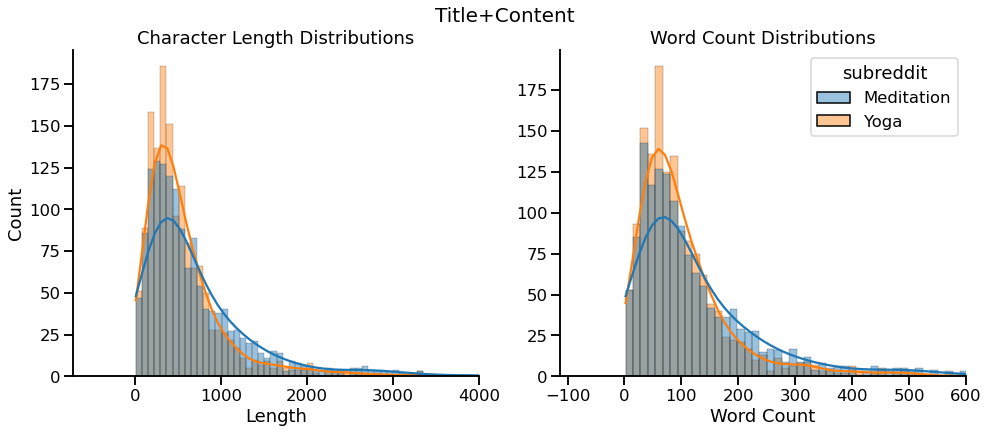

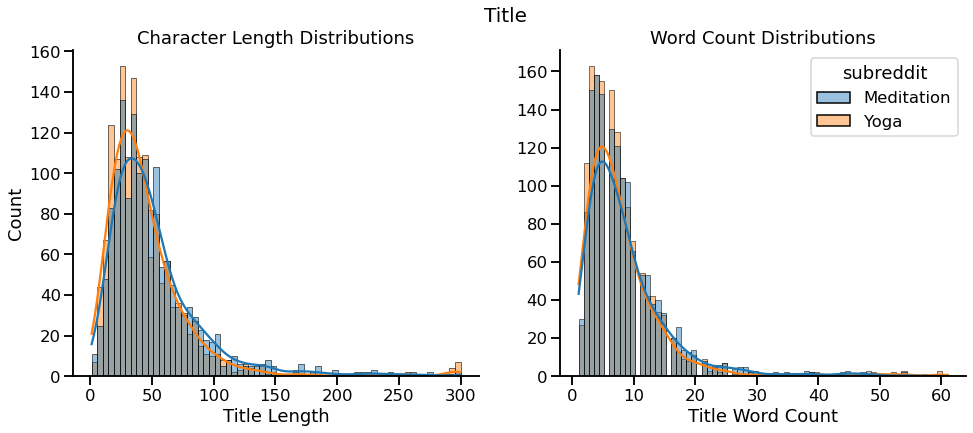

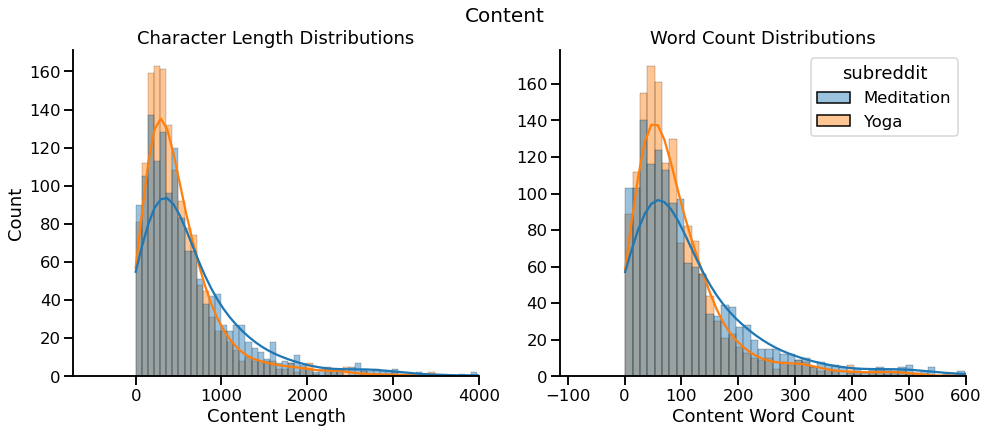

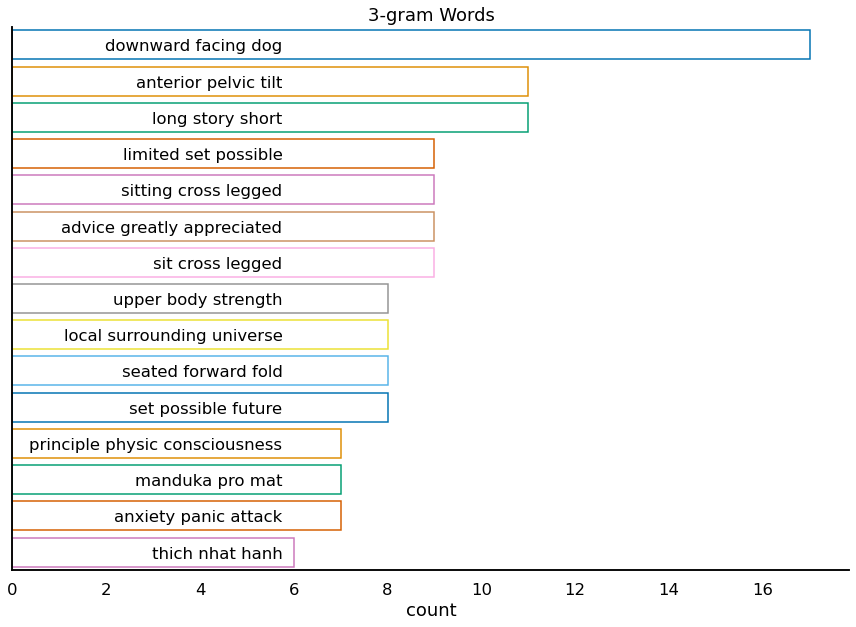

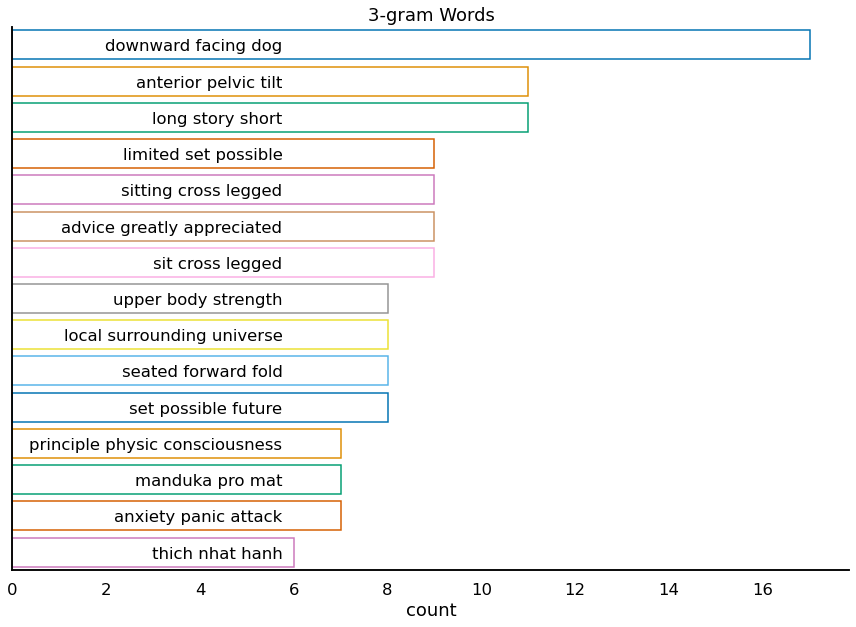

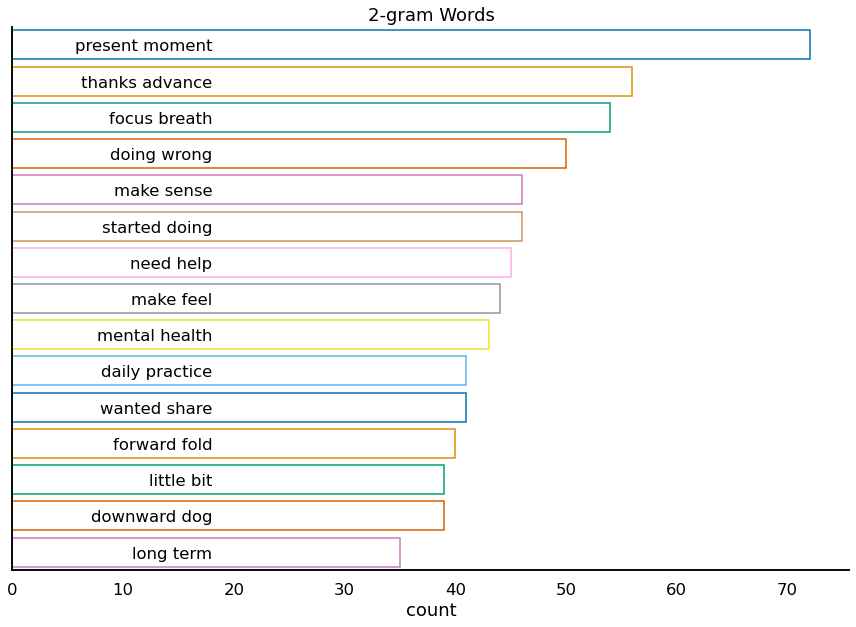

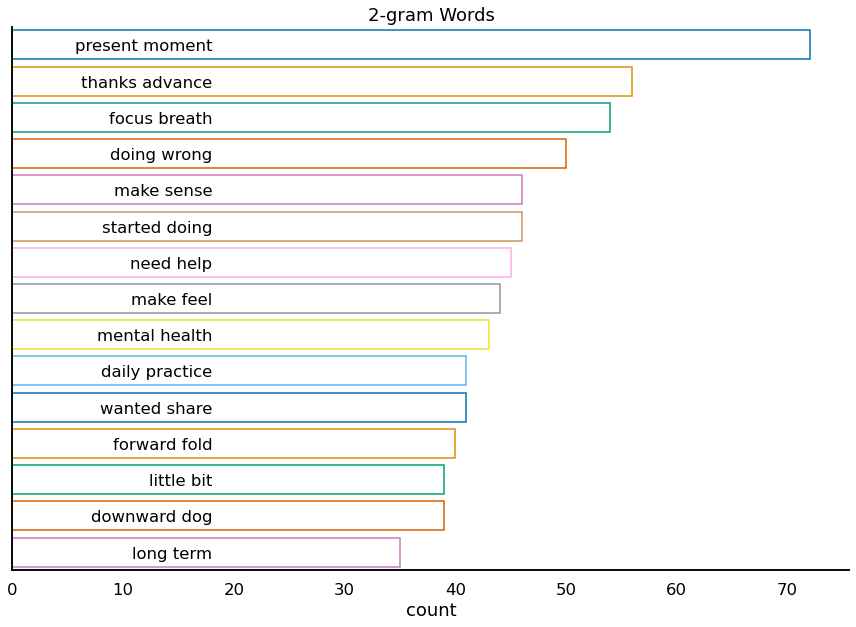

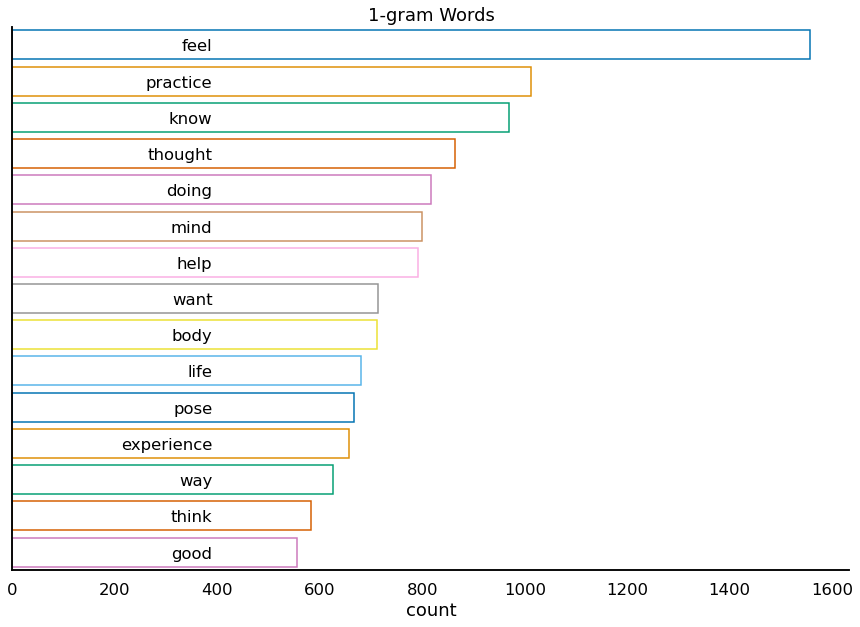

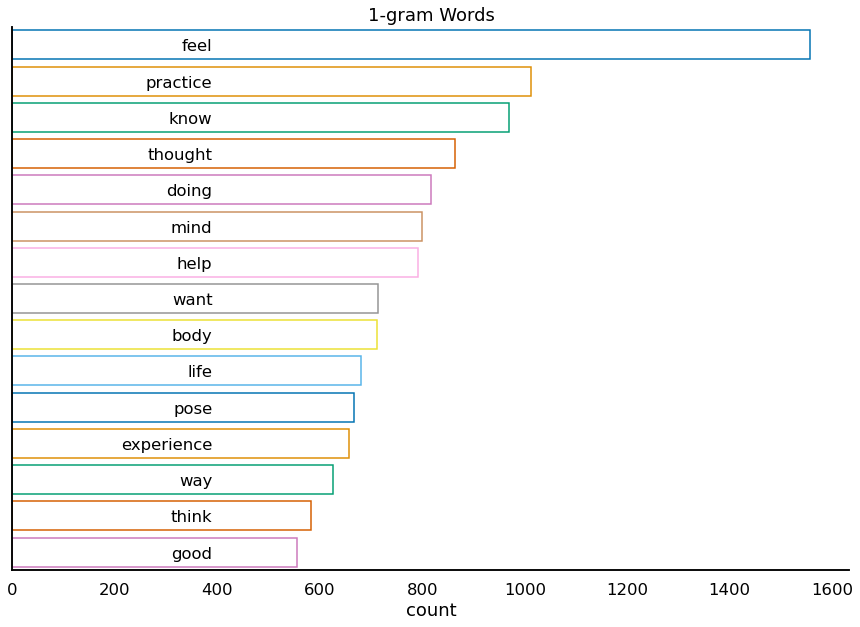

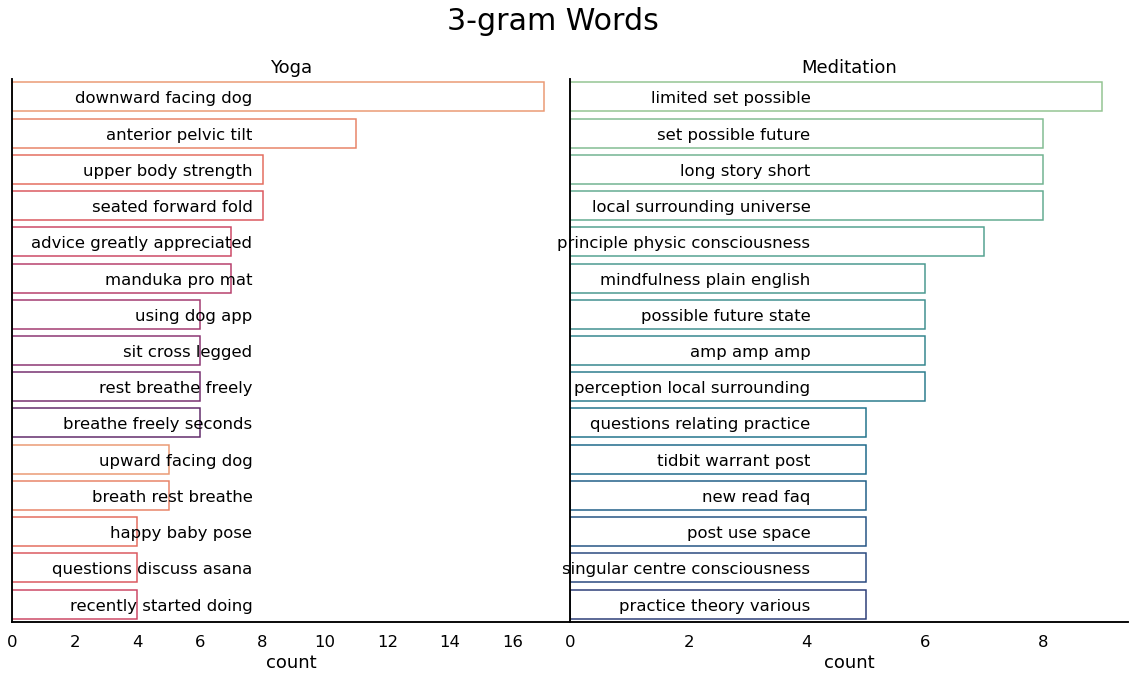

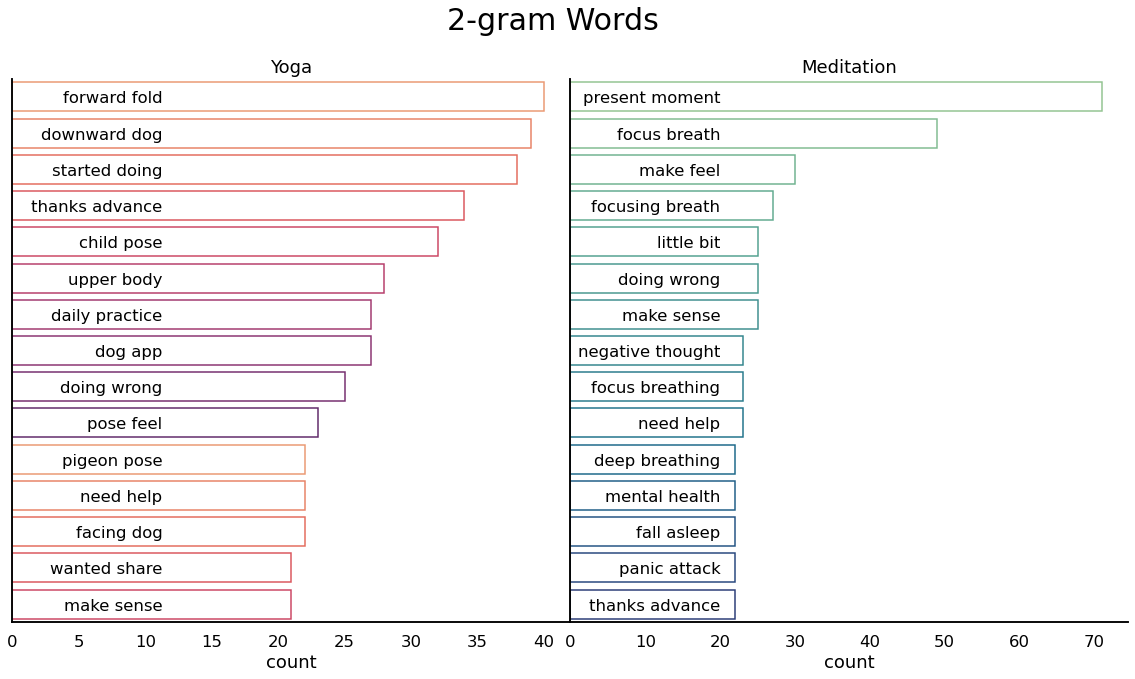

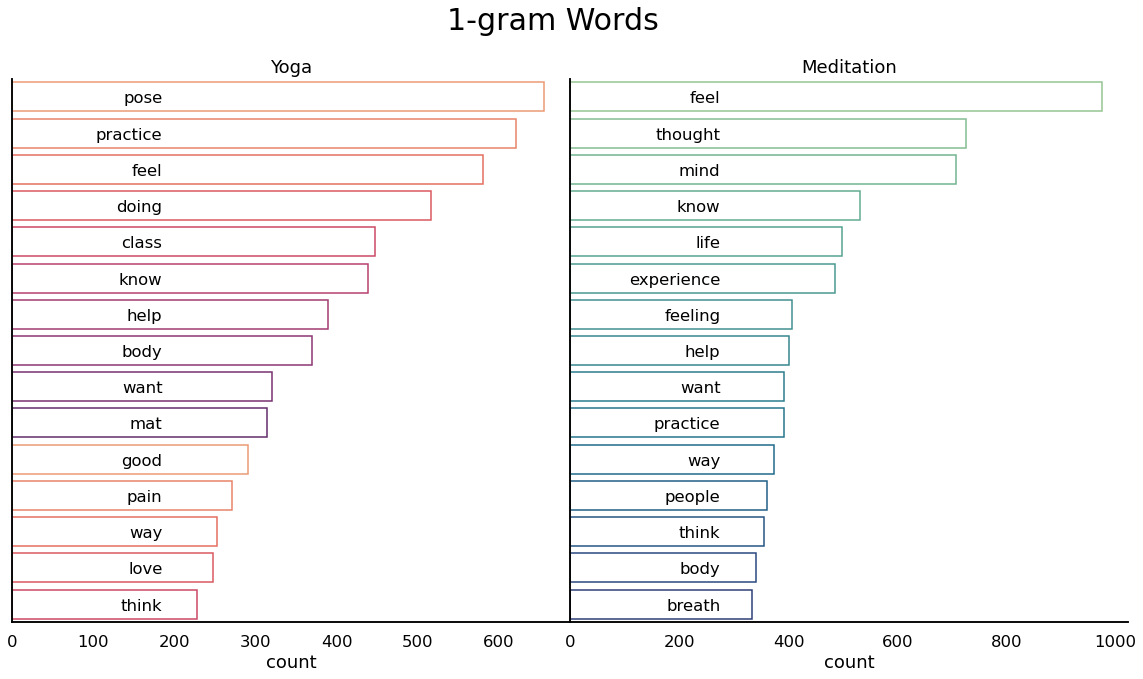

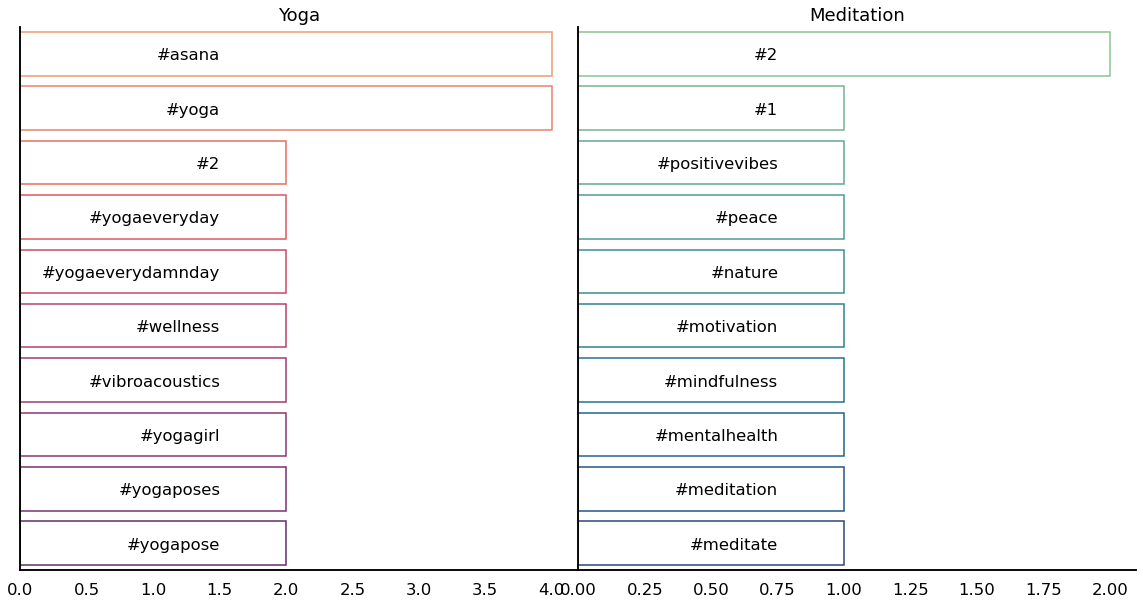

In [419]:
G = Main('reddit', to_model=False) # to see the visualization

shape:  (2960, 6)


,title,selftext,text,clean_text,created_at,subreddit
0,Hey! Does anyone know any guided meditations t...,***1) Look***\n\nBecome aware of what you see:...,Hey! Does anyone know any guided meditations t...,Hey! Does anyone know any guided meditations t...,2021-09-03 20:43:02+00:00,Meditation



Size of X train:  1381599

Baseline Accuracy - y: 0.5

Baseline Accuracy - y test: 0.5


1    1480
0    1480
Name: label, dtype: int64


Results for transformer: "CountVectorizer" & estimator: "MultinomialNB"
	Validation Score:  0.89
	Train Score:  0.994
	Test Score:  0.88

	Grid Search Results
		Best Parameters
		vec__max_df : 0.9
		vec__max_features : 3000
		vec__min_df : 2
		vec__ngram_range : (1, 1)

		Best Score  0.883
		Train Score:  0.924
		Test Score:  0.875
'MultinomialNB' object has no attribute 'feature_importances_'
	F1 - score:  0.875
	Recall (Sensitivity):  0.872
	Specificity (True Negative Rate):  0.878
	Precision:  0.878
	Accuracy:  0.875

Results for transformer: "TfidfVectorizer" & estimator: "MultinomialNB"
	Validation Score:  0.881
	Train Score:  0.991
	Test Score:  0.884

	Grid Search Results
		Best Parameters
		vec__max_features : 4000
		vec__ngram_range : (1, 1)

		Best Score  0.881
		Train Score:  0.941
		Test Score:  0.883
'MultinomialNB' object has no attribute 'feature_importances_'
	F1 - score:  0.885
	Recall (Sensitivity):  0.905
	Specificity (True Negative Rate):  0.86
	Precision:  0.866
	

Basic\nValidation Score  \
Estimator              Transformer                                
MultinomialNB          CountVectorizer                    0.890   
                       TfidfVectorizer                    0.881   
DecisionTreeClassifier TfidfVectorizer                    0.752   
                       CountVectorizer                    0.774   
RandomForestClassifier TfidfVectorizer                    0.841   

                                        Basic\nTrain Score  Basic\nTest Score  \
Estimator              Transformer                                              
MultinomialNB          CountVectorizer               0.994              0.880   
                       TfidfVectorizer               0.991              0.884   
DecisionTreeClassifier TfidfVectorizer               0.999              0.757   
                       CountVectorizer               0.999              0.787   
RandomForestClassifier TfidfVectorizer               0.999              0.855   

                                                            Grid Search\nGiven Parameters  \
Estimator              Transformer                                                          
MultinomialNB          CountVectorizer  {'vec__min_df': [2, 3], 'vec__max_df': [0.9, 0...   
                       TfidfVectorizer  {'vec__ngram_range': [(1, 1), (1, 2)], 'vec__m...   
DecisionTreeClassifier TfidfVectorizer  {'vec__ngram_range': [(1, 1), (1, 2)], 'dt__ma...   
                       CountVectorizer  {'vec__min_df': [2, 3], 'vec__max_df': [0.9, 0...   
RandomForestClassifier TfidfVectorizer  {'vec__ngram_range': [(1, 1), (1, 2)], 'rf__n_...   

                                        Grid Search\nBest Score  \
Estimator              Transformer                                
MultinomialNB          CountVectorizer                    0.883   
                       TfidfVectorizer                    0.881   
DecisionTreeClassifier TfidfVectorizer                    0.760   
                       CountVectorizer                    0.778   
RandomForestClassifier TfidfVectorizer                    0.866   

                                        Grid Search\nTrain Score  \
Estimator              Transformer                                 
MultinomialNB          CountVectorizer                     0.924   
                       TfidfVectorizer                     0.941   
DecisionTreeClassifier TfidfVectorizer                     0.820   
                       CountVectorizer                     0.842   
RandomForestClassifier TfidfVectorizer                     0.999   

                                        Grid Search\nTest Score  \
Estimator              Transformer                                
MultinomialNB          CountVectorizer                    0.875   
                       TfidfVectorizer                    0.883   
DecisionTreeClassifier TfidfVectorizer                    0.762   
                       CountVectorizer                    0.785   
RandomForestClassifier TfidfVectorizer                    0.855   

                                                        Grid Search\nBest Hyperparameters  \
Estimator              Transformer                                                          
MultinomialNB          CountVectorizer  {'vec__max_df': 0.9, 'vec__max_features': 3000...   
                       TfidfVectorizer  {'vec__max_features': 4000, 'vec__ngram_range'...   
DecisionTreeClassifier TfidfVectorizer  {'dt__max_depth': 20, 'dt__min_samples_leaf': ...   
                       CountVectorizer  {'dt__max_depth': 30, 'dt__min_samples_leaf': ...   
RandomForestClassifier TfidfVectorizer  {'rf__max_depth': None, 'rf__n_estimators': 10...   

                                        F1 - score  Recall (Sensitivity)  \
Estimator              Transformer                                         
MultinomialNB          CountVectorizer       0.875                 0.872   
                       TfidfVectorizer       0.885   

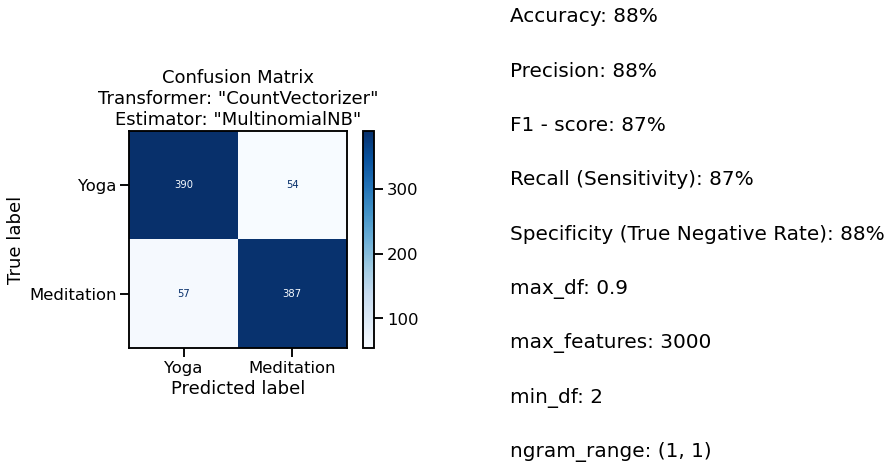

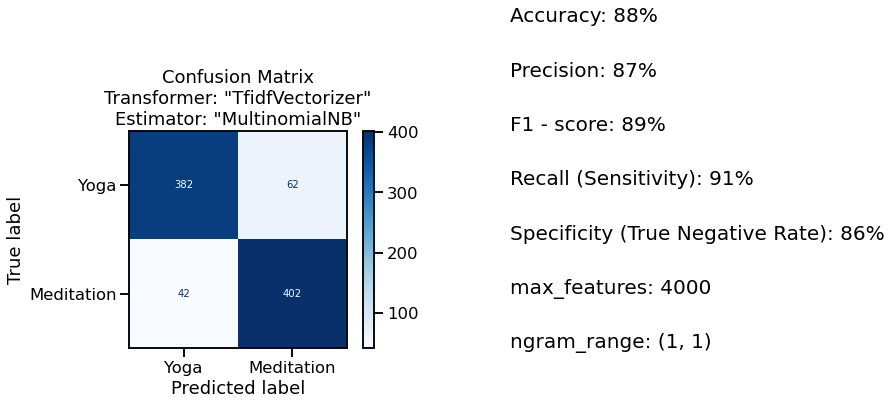

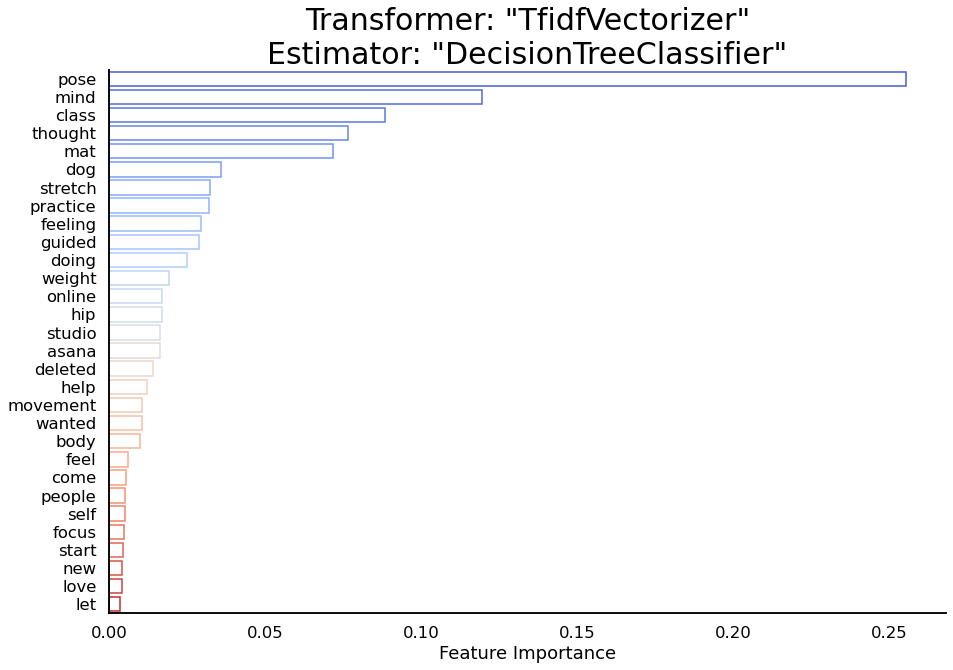

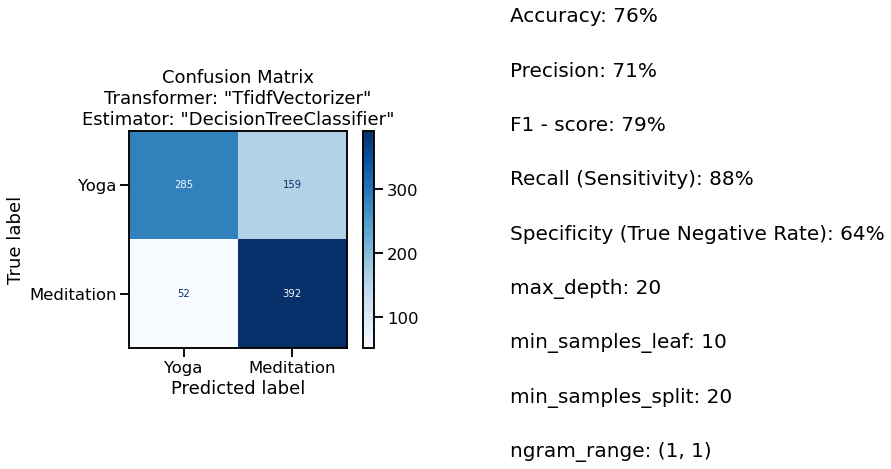

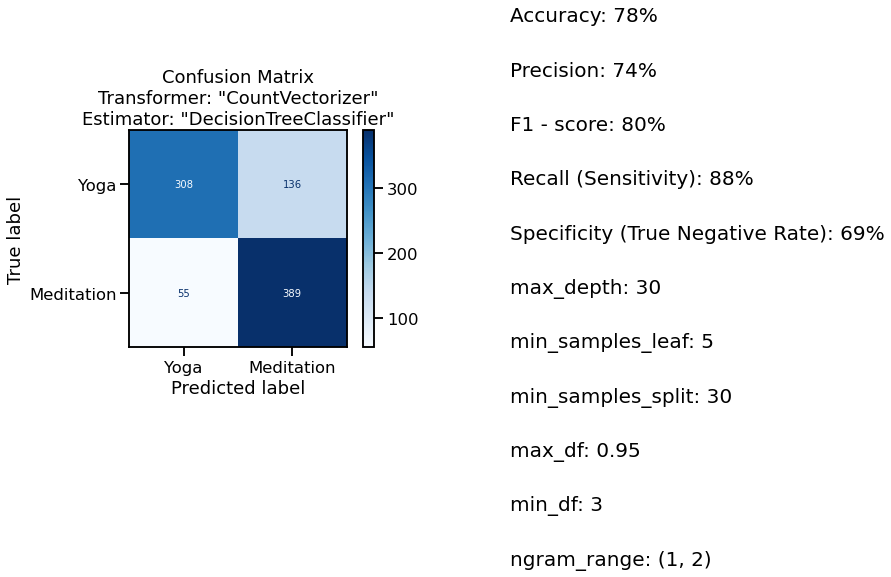

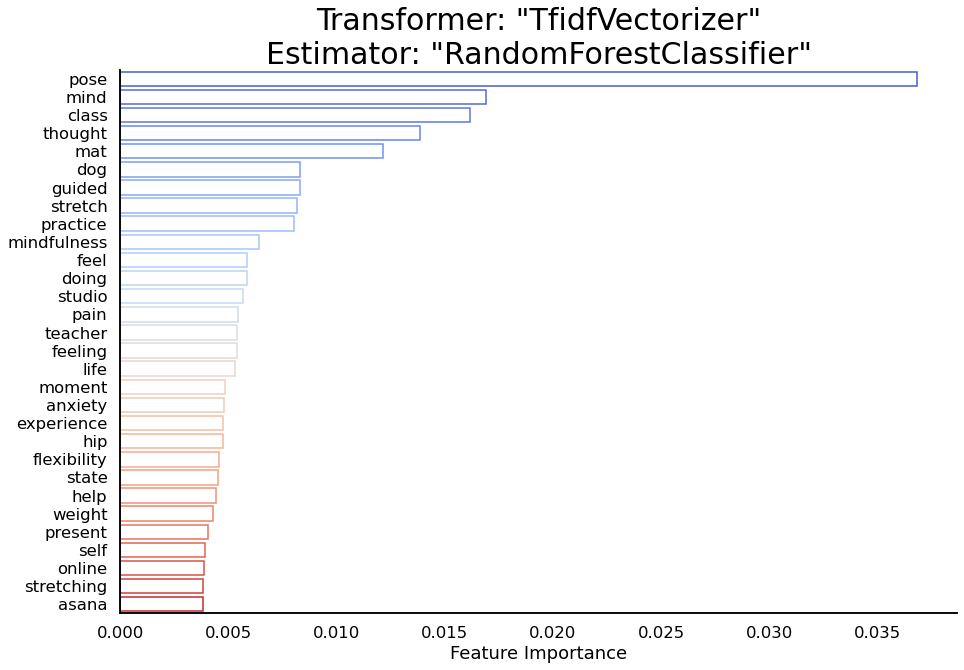

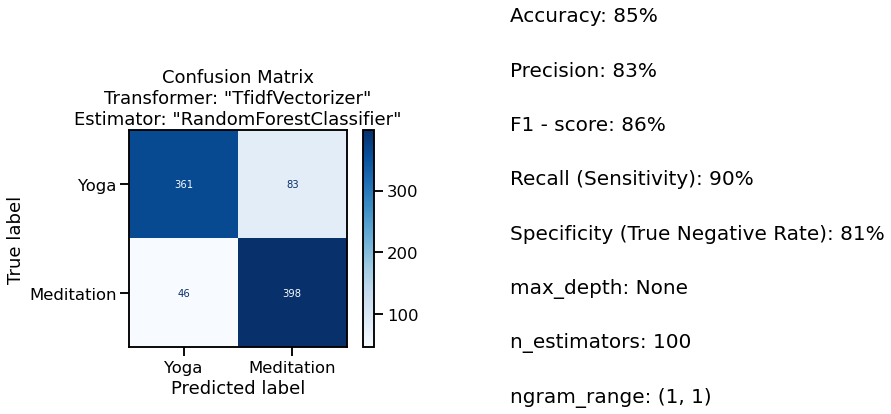

In [386]:
H = Main('reddit', to_model=True)

In [397]:
info = H.info_df.drop(columns=['Grid Search\nGiven Parameters', 'Grid Search\nBest Hyperparameters'])
info.columns = ['Validation Score', 'Train Score', 'Test Score',
       'Best Score (GS)', 'Train Score (GS)',
       'Test Score (GS)', 'F1 - score', 'Recall (Sensitivity)',
       'Specificity (True Negative Rate)', 'Precision', 'Accuracy']
info.sort_values('Accuracy', ascending=False)

Validation Score  Train Score  \
Estimator              Transformer                                      
MultinomialNB          TfidfVectorizer             0.881        0.991   
                       CountVectorizer             0.890        0.994   
RandomForestClassifier TfidfVectorizer             0.841        0.999   
DecisionTreeClassifier CountVectorizer             0.774        0.999   
                       TfidfVectorizer             0.752        0.999   

                                        Test Score  Best Score (GS)  \
Estimator              Transformer                                    
MultinomialNB          TfidfVectorizer       0.884            0.881   
                       CountVectorizer       0.880            0.883   
RandomForestClassifier TfidfVectorizer       0.855            0.866   
DecisionTreeClassifier CountVectorizer       0.787            0.778   
                       TfidfVectorizer       0.757            0.760   

                                        Train Score (GS)  Test Score (GS)  \
Estimator              Transformer                                          
MultinomialNB          TfidfVectorizer             0.941            0.883   
                       CountVectorizer             0.924            0.875   
RandomForestClassifier TfidfVectorizer             0.999            0.855   
DecisionTreeClassifier CountVectorizer             0.842            0.785   
                       TfidfVectorizer             0.820            0.762   

                                        F1 - score  Recall (Sensitivity)  \
Estimator              Transformer                                         
MultinomialNB          TfidfVectorizer       0.885                 0.905   
                       CountVectorizer       0.875                 0.872   
RandomForestClassifier TfidfVectorizer       0.861                 0.896   
DecisionTreeClassifier CountVectorizer       0.803                 0.876   
                       TfidfVectorizer       0.788                 0.883   

                                        Specificity (True Negative Rate)  \
Estimator              Transformer                                         
MultinomialNB          TfidfVectorizer                             0.860   
                       CountVectorizer                             0.878   
RandomForestClassifier TfidfVectorizer                             0.813   
DecisionTreeClassifier CountVectorizer                             0.694   
                       TfidfVectorizer                             0.642   

                                        Precision  Accuracy  
Estimator              Transformer                           
MultinomialNB          TfidfVectorizer      0.866     0.883  
                       CountVectorizer      0.878     0.875  
RandomForestClassifier TfidfVectorizer      0.827     0.855  
DecisionTreeClassifier CountVectorizer      0.741     0.785  
                       TfidfVectorizer      0.711     0.762

In [204]:
# Import export_text from sklearn.tree module.


# Print out tree in plaintext.
print(export_text(H.mdl_dt_tvec._final_estimator, feature_names=list(H.X_train_df.columns)))

|--- pose <= 0.01
|   |--- mind <= 0.00
|   |   |--- poses <= 0.02
|   |   |   |--- mat <= 0.03
|   |   |   |   |--- class <= 0.05
|   |   |   |   |   |--- thoughts <= 0.04
|   |   |   |   |   |   |--- dog <= 0.01
|   |   |   |   |   |   |   |--- guided <= 0.07
|   |   |   |   |   |   |   |   |--- practice <= 0.07
|   |   |   |   |   |   |   |   |   |--- strength <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- feeling <= 0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- feeling >  0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- strength >  0.03
|   |   |   |   |   |   |   |   |   |   |--- strength <= 0.23
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- strength >  0.23
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- practice >  0.

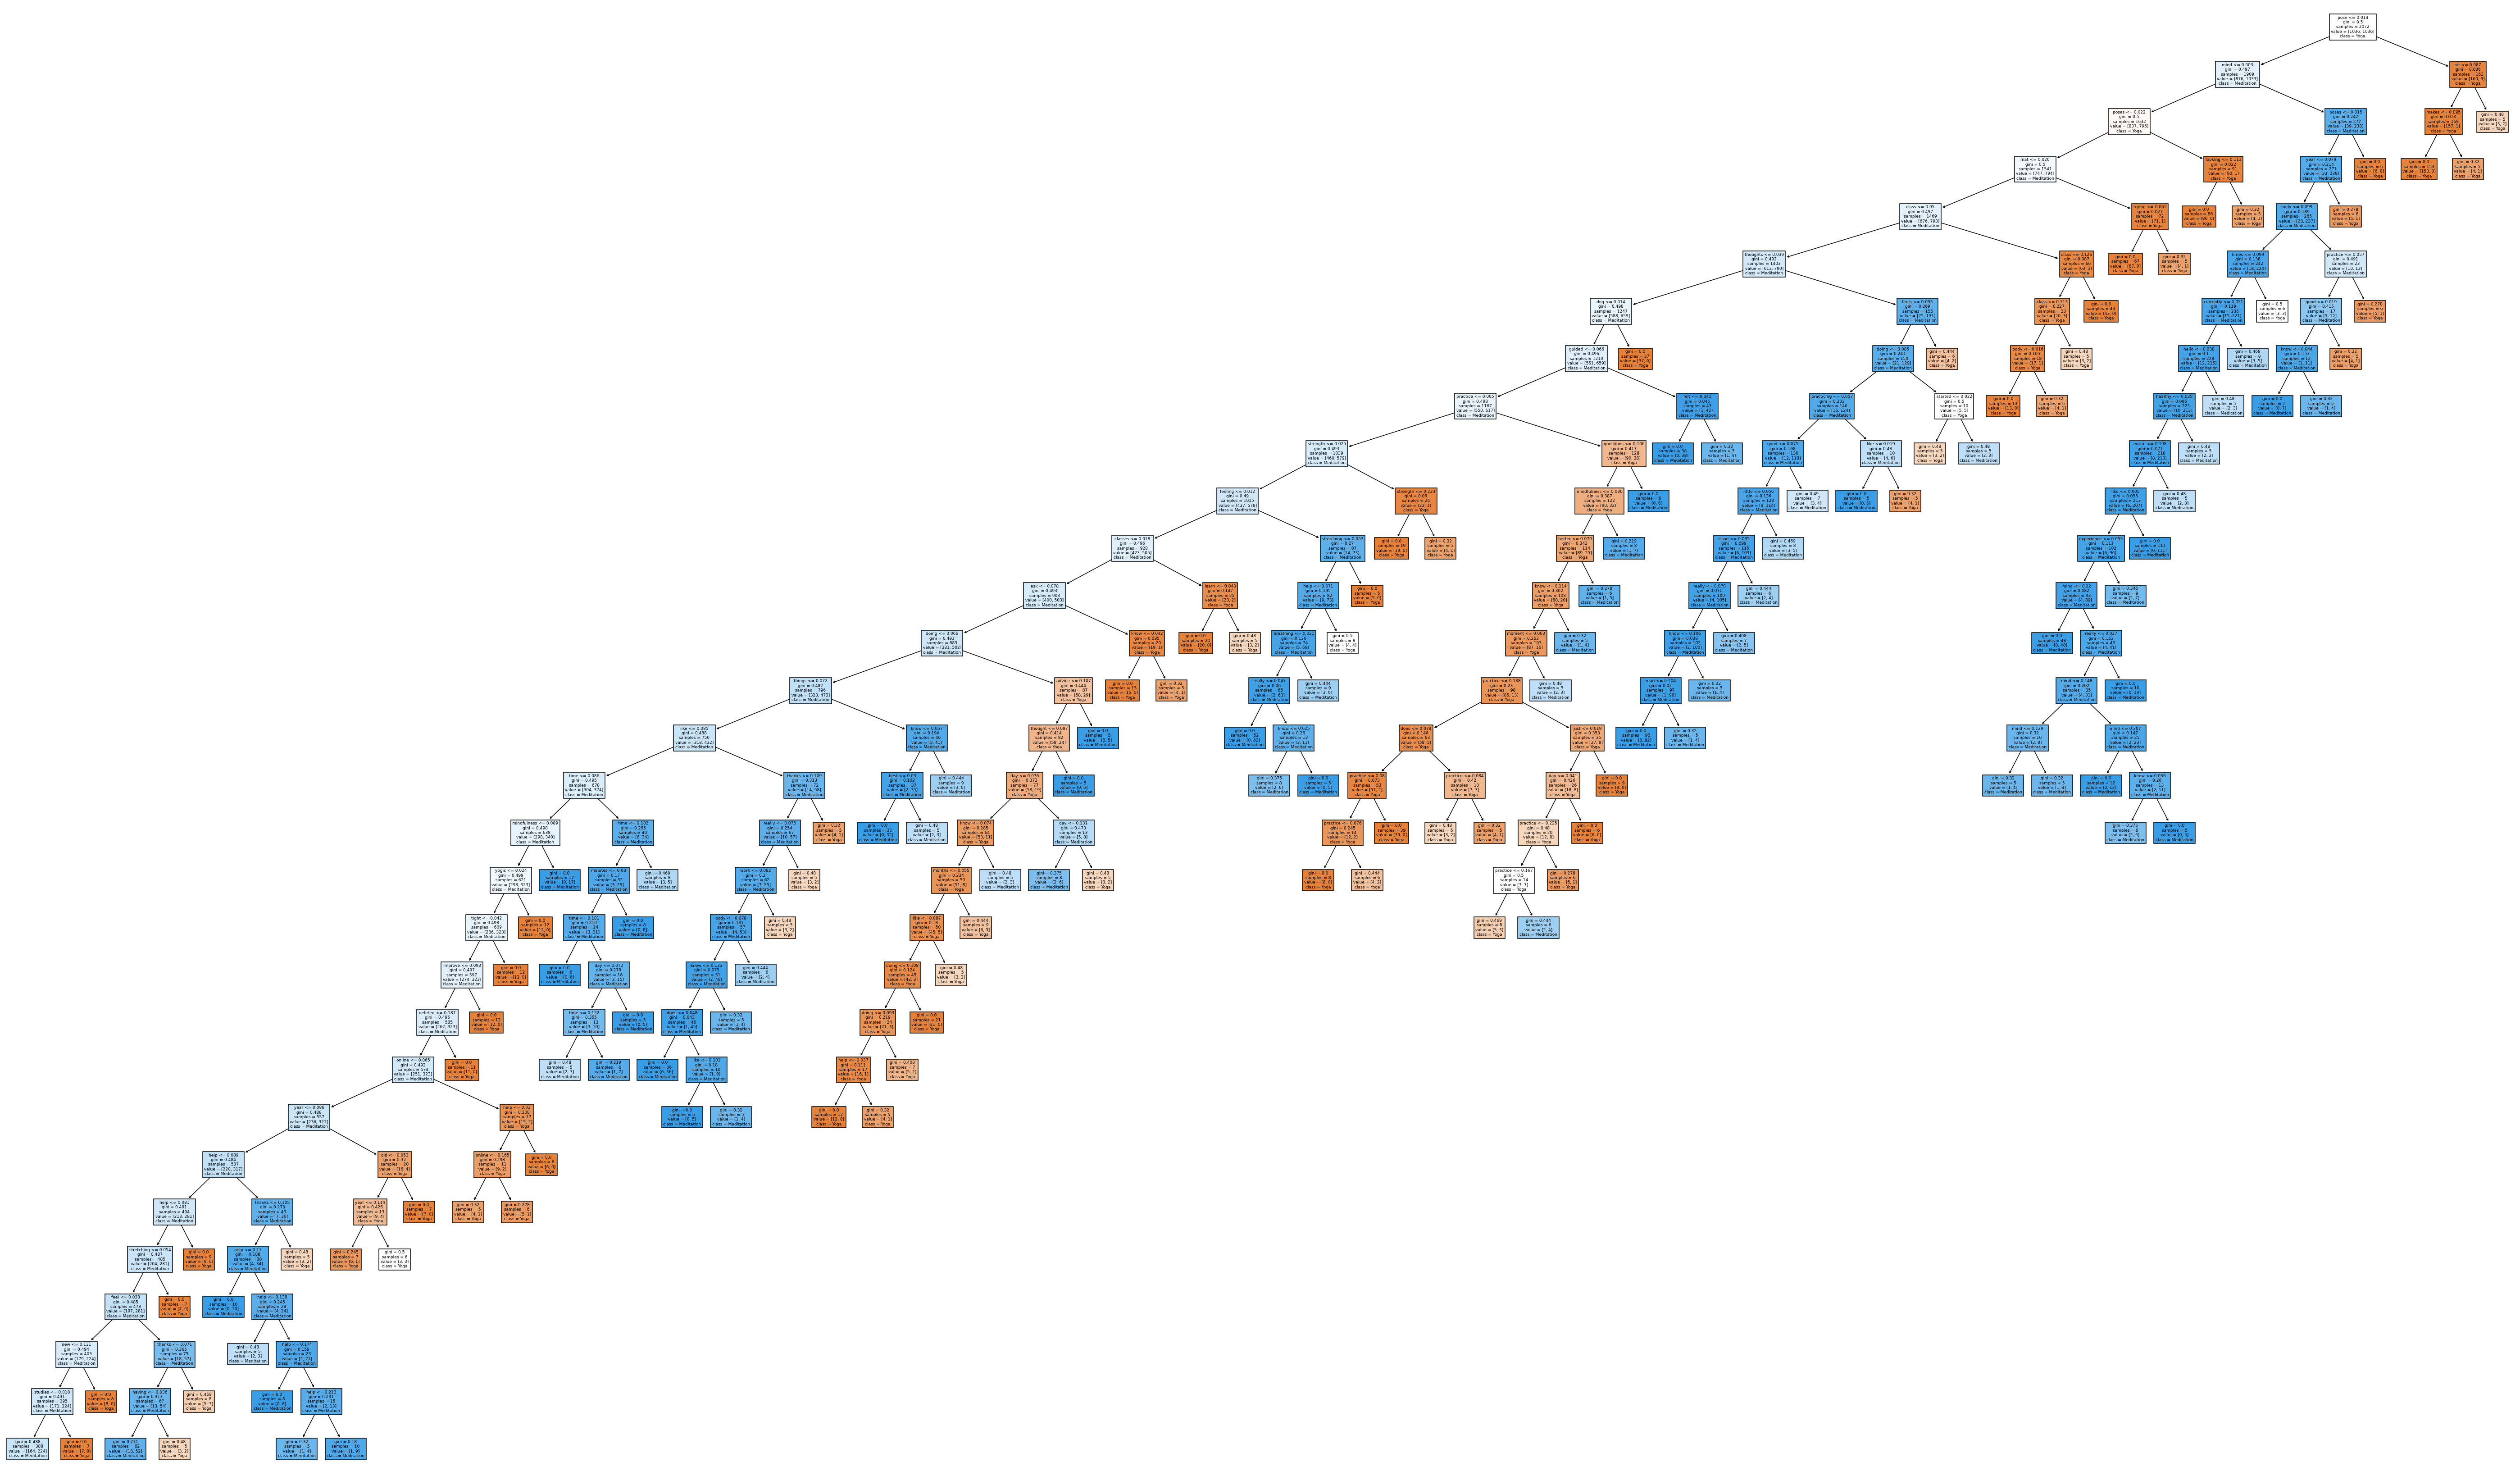

In [203]:
# Import plot_tree from sklearn.tree module.
from sklearn.tree import plot_tree, export_text

# Establish size of figure.
plt.figure(figsize = (100, 60))

# Plot our tree.
plot_tree(
    H.mdl_dt_tvec._final_estimator,
    feature_names=H.X_train_df.columns,
    class_names=['Yoga', 'Meditation'],
    filled=True,
#     max_depth=3
);